In [80]:
import torch
import torch.nn as nn
import sklearn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


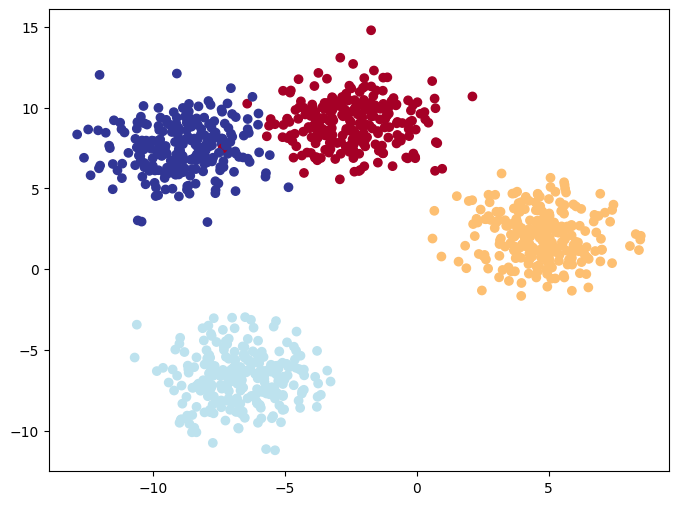

In [81]:
from sklearn.datasets import make_blobs

X, Y = make_blobs(n_samples=1000, centers=4, cluster_std=1.5, n_features=2, random_state=42)
plt.figure(figsize=(8, 6))
plt.scatter(X[:,0], X[:,1], c=Y, cmap=plt.cm.RdYlBu)
plt.show()

In [82]:
Y.dtype

dtype('int64')

In [83]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

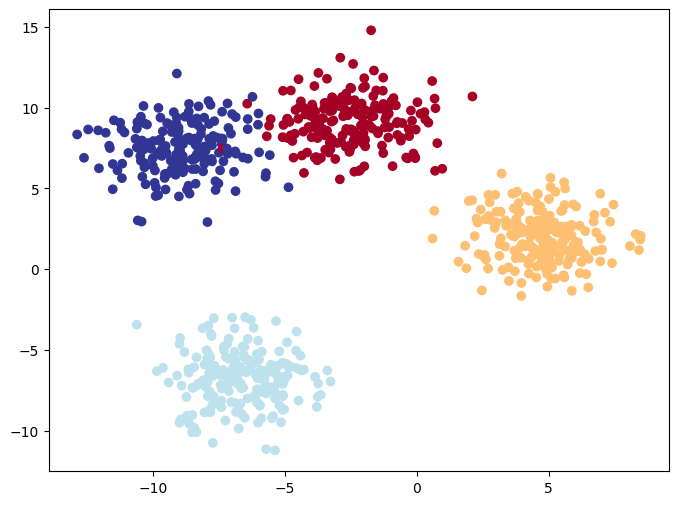

In [84]:
plt.figure(figsize=(8, 6))
plt.scatter(X_train[:,0], X_train[:,1], c=Y_train, cmap=plt.cm.RdYlBu)
plt.show()

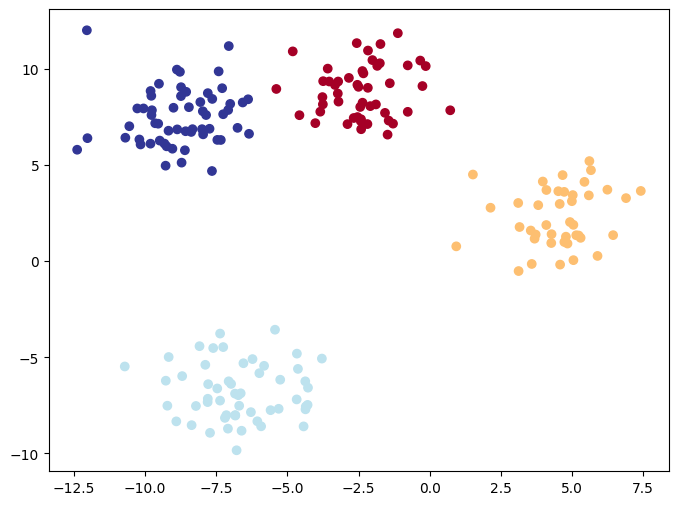

In [85]:
plt.figure(figsize=(8, 6))
plt.scatter(X_test[:,0], X_test[:,1], c=Y_test, cmap=plt.cm.RdYlBu)
plt.show()

In [86]:
device = "cuda" if torch.cuda.is_available() else "cpu"

X_train, Y_train = torch.tensor(X_train).to(device), torch.tensor(Y_train).to(device)
X_test, Y_test = torch.tensor(X_test).to(device), torch.tensor(Y_test).to(device)

In [87]:
device

'cuda'

In [88]:
torch.unique(Y_train)

tensor([0, 1, 2, 3], device='cuda:0')

In [89]:

model = nn.Sequential(
    nn.Linear(in_features=2, out_features=10),
    nn.ReLU(),
    nn.Linear(in_features=10, out_features=10),
    nn.ReLU(),
    nn.Linear(in_features=10, out_features=10),
    nn.ReLU(),
    nn.Linear(in_features=10, out_features=10),
    nn.ReLU(),
    nn.Linear(in_features=10, out_features=4)
).to(device)

model

Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=10, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10, out_features=10, bias=True)
  (5): ReLU()
  (6): Linear(in_features=10, out_features=10, bias=True)
  (7): ReLU()
  (8): Linear(in_features=10, out_features=4, bias=True)
)

In [90]:

with torch.inference_mode():
    # print(X_train)
    y_logits = model(X_train.type(torch.float32))   
    ypreds = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)
Y_train

tensor([1, 0, 2, 2, 0, 0, 0, 1, 3, 0, 0, 0, 3, 2, 3, 2, 1, 1, 3, 2, 2, 2, 3, 1,
        3, 2, 3, 0, 1, 0, 0, 1, 1, 3, 0, 2, 2, 1, 1, 3, 1, 1, 2, 3, 3, 0, 0, 0,
        1, 0, 0, 0, 2, 0, 1, 1, 0, 0, 2, 2, 3, 1, 0, 2, 1, 3, 2, 2, 2, 1, 0, 2,
        3, 1, 1, 1, 2, 0, 0, 1, 2, 3, 1, 3, 3, 2, 3, 3, 2, 2, 1, 0, 0, 1, 2, 1,
        3, 1, 2, 1, 3, 3, 3, 0, 2, 1, 2, 3, 1, 1, 2, 0, 3, 3, 2, 0, 2, 0, 3, 2,
        0, 0, 2, 2, 0, 1, 2, 0, 3, 3, 2, 3, 2, 1, 3, 1, 1, 1, 1, 0, 0, 1, 0, 2,
        3, 0, 0, 0, 0, 0, 1, 0, 3, 0, 0, 2, 2, 0, 0, 3, 0, 3, 3, 3, 0, 2, 0, 1,
        2, 2, 2, 3, 0, 1, 1, 0, 1, 2, 0, 3, 2, 1, 3, 2, 3, 0, 3, 1, 1, 2, 2, 2,
        2, 2, 2, 0, 3, 3, 2, 1, 1, 2, 3, 1, 0, 0, 1, 3, 0, 1, 3, 3, 2, 3, 3, 3,
        1, 0, 0, 1, 0, 3, 2, 1, 0, 3, 0, 0, 3, 1, 0, 1, 0, 2, 2, 0, 0, 3, 3, 2,
        0, 2, 0, 3, 1, 3, 0, 2, 2, 0, 1, 1, 0, 2, 1, 1, 1, 0, 1, 3, 1, 1, 0, 2,
        2, 3, 1, 0, 1, 2, 3, 1, 2, 0, 3, 1, 3, 3, 3, 0, 3, 3, 3, 2, 3, 3, 1, 0,
        2, 2, 2, 2, 3, 1, 2, 2, 0, 2, 3,

In [91]:
lossfn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

In [92]:
def accuracyfn(ytrue, ypred):
    correct = torch.eq(ytrue, ypred).sum().item()
    acc = correct/len(ypred)
    return acc*100

In [93]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 400

for epoch in range(epochs):
    
    model.train()
    
    y_logits = model(X_train.type(torch.float32))
    ypred = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)  #turn logits to pred probabilities to prediction labels
    
    loss = lossfn(y_logits, Y_train.type(torch.LongTensor).to(device))
    acc = accuracyfn(ytrue=Y_train,
                     ypred=ypred)
    
    optimizer.zero_grad()
    
    loss.backward()
    
    optimizer.step()
    
    model.eval()
    with torch.inference_mode():
        test_logits = model(X_test.type(torch.float32))
        testpreds = torch.argmax(torch.softmax(test_logits, dim=1), dim=1)
        
        testloss = lossfn(test_logits, Y_test.type(torch.LongTensor).to(device))
        testacc = accuracyfn(ytrue = Y_test,
                             ypred = testpreds)
    
    if epoch % 10 == 0:
        print(f"epochs: {epoch} | loss : {loss} |accuracy : {acc} | Test loss : {testloss} | test accuracy : {testacc}")
            

epochs: 0 | loss : 1.3787155151367188 |accuracy : 26.125 | Test loss : 1.3851646184921265 | test accuracy : 20.5
epochs: 10 | loss : 1.3209125995635986 |accuracy : 26.125 | Test loss : 1.333479404449463 | test accuracy : 20.5
epochs: 20 | loss : 1.2256646156311035 |accuracy : 29.375 | Test loss : 1.2444990873336792 | test accuracy : 41.0
epochs: 30 | loss : 1.0287991762161255 |accuracy : 73.0 | Test loss : 1.0697031021118164 | test accuracy : 69.5
epochs: 40 | loss : 0.8354939222335815 |accuracy : 75.0 | Test loss : 0.8855844140052795 | test accuracy : 71.0
epochs: 50 | loss : 0.6439432501792908 |accuracy : 76.875 | Test loss : 0.6968258023262024 | test accuracy : 75.5
epochs: 60 | loss : 0.5084231495857239 |accuracy : 91.875 | Test loss : 0.5539340376853943 | test accuracy : 91.0
epochs: 70 | loss : 0.4005194902420044 |accuracy : 95.125 | Test loss : 0.4351435601711273 | test accuracy : 93.5
epochs: 80 | loss : 0.3026319742202759 |accuracy : 97.0 | Test loss : 0.3242080807685852 | tes

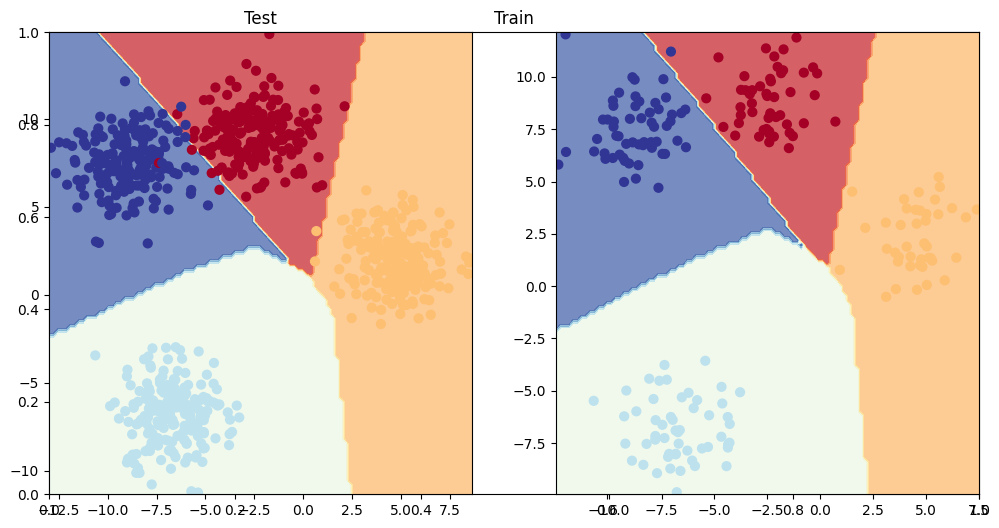

In [94]:
from helper_fn import plot_decision_boundary
plt.figure(figsize=(12,6))
plt.title("Train")
plt.subplot(1,2,1)
plot_decision_boundary(model, X_train, Y_train)
plt.title("Test")
plt.subplot(1,2,2)
plot_decision_boundary(model, X_test, Y_test)